In [ ]:
# import necessay libraries
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
# Constants for training and model configuration
random_seed = 42       # Random seed for reproducibility
learning_rate = 0.001  # Learning rate for the optimizer
BATCH_SIZE = 32        # Batch size for training and evaluation
no_of_epochs = 15      # Number of training epochs
image_size = 32        # Image size (assumed to be 32x32 pixels)
no_of_classes = 10     # Number of classes (e.g., for classification tasks)

In [ ]:
# Define image transformations
transformations = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize images to 32x32 pixels
    transforms.ToTensor()         # Convert images to tensors
])

# Create the training dataset
training_dataset = datasets.MNIST(root='mnist_data', train=True, transform=transformations, download=True)

# Create the validation dataset
validation_dataset = datasets.MNIST(root='mnist_data', train=False, transform=transformations)

# Create data loaders for training and validation
train_loader = DataLoader(dataset=training_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [ ]:
def train_model(train_loader, model, criterion, optimizer, device):
    # Set the model in training mode
    model.train()
    total_loss = 0  # Initialize a variable to track the total loss during training

    # Iterate over the training data in batches
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero out the gradients from the previous iteration
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device (e.g., GPU)
        outputs, _ = model(inputs)  # Forward pass: compute model predictions
        loss = criterion(outputs, labels)  # Calculate the loss between predictions and true labels
        total_loss += loss.item() * inputs.size(0)  # Accumulate the running loss
        loss.backward()  # Backpropagation: compute gradients
        optimizer.step()  # Update model parameters using the optimizer

    # Calculate the average loss for the entire epoch
    average_loss = total_loss / len(train_loader.dataset)

    # Return the updated model, optimizer, and the average epoch loss
    return model, optimizer, average_loss


In [ ]:
def evaluate_model(valid_loader, model, criterion, device):
    # Set the model in evaluation mode
    model.eval()
    total_loss = 0  # Initialize a variable to track the total loss during validation

    # Iterate over the validation data in batches
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the specified device (e.g., GPU)
        outputs, _ = model(inputs)  # Forward pass: compute model predictions
        loss = criterion(outputs, labels)  # Calculate the loss between predictions and true labels
        total_loss += loss.item() * inputs.size(0)  # Accumulate the running loss

    # Calculate the average loss for the entire validation dataset
    average_loss = total_loss / len(valid_loader.dataset)

    # Return the model and the average epoch loss
    return model, average_loss


In [ ]:
def calculate_accuracy(model, data_loader, device):
    # Set the model in evaluation mode
    model.eval()
    correct_predictions = 0  # Initialize a variable to count the correct predictions
    total_predictions = 0   # Initialize a variable to count the total predictions

    with torch.no_grad():
        # Iterate over the data loader (e.g., validation or test data)
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device (e.g., GPU)
            outputs, _ = model(inputs)  # Forward pass: compute model predictions
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest probability
            total_predictions += targets.size(0)  # Increase the count of total predictions
            correct_predictions += (predicted == targets).sum().item()  # Count correct predictions

    # Calculate the accuracy by dividing the correct predictions by the total predictions
    accuracy = correct_predictions / total_predictions
    return accuracy


In [ ]:
# Lists to store training and validation losses for each epoch
training_losses_list = []  # Store training losses during training
validation_losses_list = []  # Store validation losses during training

In [ ]:

def run_training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    best_validation_loss = 1e10   # Initialize a variable to track the best validation loss
    training_losses = []  # Initialize a list to store training losses for each epoch
    validation_losses = []  # Initialize a list to store validation losses for each epoch

    for epoch in range(epochs):
        # Perform training for the current epoch
        model, optimizer, train_loss = train_model(train_loader, model, criterion, optimizer, device)
        training_losses.append(train_loss)  # Append the training loss to the list

        with torch.no_grad():
            # Perform validation for the current epoch
            model, validation_loss = evaluate_model(valid_loader, model, criterion, device)
            validation_losses.append(validation_loss)  # Append the validation loss to the list

        if epoch % print_every == (print_every - 1):
            # Calculate and print training and validation metrics for the current epoch
            train_accuracy = calculate_accuracy(model, train_loader, device=device)
            valid_accuracy = calculate_accuracy(model, valid_loader, device=device)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {validation_loss:.4f}\t'
                  f'Train accuracy: {100 * train_accuracy:.2f}\t'
                  f'Valid accuracy: {100 * valid_accuracy:.2f}')

    # Append training and validation losses to their respective lists
    training_losses_list.append(training_losses)
    validation_losses_list.append(validation_losses)

    # Return the updated model, optimizer, and lists of training and validation losses
    return model, optimizer, (training_losses, validation_losses)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CustomLeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.activation1 = nn.Tanh()
        self.pool1 = nn.AvgPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.activation2 = nn.Tanh()
        self.pool2 = nn.AvgPool2d(kernel_size=2)

        self.conv3 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1)
        self.activation3 = nn.Tanh()

        # Fully connected layers
        self.fc1 = nn.Linear(in_features=120, out_features=84)
        self.activation4 = nn.Tanh()
        self.fc2 = nn.Linear(in_features=84, out_features=num_classes)

    def forward(self, x):
        # Convolutional layer 1
        x = self.conv1(x)
        x = self.activation1(x)
        x = self.pool1(x)

        # Convolutional layer 2
        x = self.conv2(x)
        x = self.activation2(x)
        x = self.pool2(x)

        # Convolutional layer 3
        x = self.conv3(x)
        x = self.activation3(x)

        # Flatten the output for fully connected layers
        x = x.view(x.size(0), -1)

        # Fully connected layer 1
        x = self.fc1(x)
        x = self.activation4(x)

        # Fully connected layer 2
        x = self.fc2(x)

        # Compute class probabilities using softmax
        probabilities = F.softmax(x, dim=1)

        return x, probabilities


In [ ]:
# Set the seed for random number generation to ensure reproducibility
torch.manual_seed(random_seed)

# Determine if CUDA (GPU) is available and set the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate the LeNet5 model and move it to the specified device
lenet_model = CustomLeNet5(no_of_classes).to(device)

# Initialize the optimizer using Adam with the specified learning rate
optimizer = torch.optim.Adam(lenet_model.parameters(), lr=learning_rate)

# Define the loss function for classification tasks, specifically Cross-Entropy Loss
classification_criterion = nn.CrossEntropyLoss()


In [ ]:
# Perform the training loop to train the model
model, optimizer, _ = run_training_loop(lenet_model, classification_criterion, optimizer, train_loader, valid_loader, no_of_epochs, device)

02:08:41 --- Epoch: 0	Train loss: 0.2290	Valid loss: 0.1020	Train accuracy: 96.84	Valid accuracy: 96.81
02:09:37 --- Epoch: 1	Train loss: 0.0762	Valid loss: 0.0619	Train accuracy: 98.39	Valid accuracy: 98.19
02:10:33 --- Epoch: 2	Train loss: 0.0550	Valid loss: 0.0542	Train accuracy: 98.59	Valid accuracy: 98.45
02:11:29 --- Epoch: 3	Train loss: 0.0438	Valid loss: 0.0486	Train accuracy: 99.07	Valid accuracy: 98.41
02:12:25 --- Epoch: 4	Train loss: 0.0343	Valid loss: 0.0416	Train accuracy: 99.25	Valid accuracy: 98.75
02:13:20 --- Epoch: 5	Train loss: 0.0299	Valid loss: 0.0422	Train accuracy: 99.41	Valid accuracy: 98.66
02:14:17 --- Epoch: 6	Train loss: 0.0241	Valid loss: 0.0409	Train accuracy: 99.47	Valid accuracy: 98.70
02:15:12 --- Epoch: 7	Train loss: 0.0228	Valid loss: 0.0418	Train accuracy: 99.57	Valid accuracy: 98.69
02:16:08 --- Epoch: 8	Train loss: 0.0186	Valid loss: 0.0447	Train accuracy: 99.53	Valid accuracy: 98.70
02:17:04 --- Epoch: 9	Train loss: 0.0161	Valid loss: 0.0468	Trai

In [ ]:
# Define a function to plot training and validation losses
def plot_losses(train_losses, valid_losses):
    plt.style.use('seaborn')  # Set the plotting style to 'seaborn'

    # Convert the lists of losses to NumPy arrays for plotting
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    # Create a new figure and axis for the plot
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # Plot the training loss in blue and the validation loss in red
    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')

    # Set the title, x-axis label, and y-axis label for the plot
    ax.set(title="Loss over epochs", xlabel='Epoch', ylabel='Loss')

    # Add a legend to the plot to distinguish training and validation losses
    ax.legend()

    # Display the plot
    fig.show()

    plt.style.use('default')  # Reset the plotting style to the default style


[[0.22898623548870287, 0.07624198038863639, 0.05500372431507955, 0.04383145153702547, 0.034304649300997456, 0.029885643526430552, 0.024088861410416818, 0.02278313860024015, 0.01858482770139041, 0.016081514764518943, 0.014844350358114267, 0.014600480437810377, 0.0114513553815661, 0.012632547761145784, 0.011919470371865706]]
[[0.10200825361795723, 0.06185830005928874, 0.05424961919002235, 0.04861550660654902, 0.04158412355263717, 0.04220494977540802, 0.04088424418305513, 0.04178494445052929, 0.044650415192567745, 0.046774853838683336, 0.04920786139651609, 0.04856407261891145, 0.04586434351127828, 0.048574257184952147, 0.04583447468491795]]


<ipython-input-87-3dd2e4362891>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')  # Set the plotting style to 'seaborn'


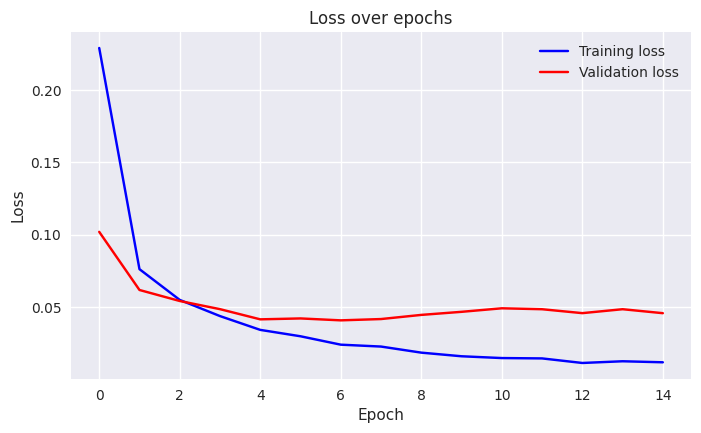

In [ ]:
# Print the training and validation losses
print(training_losses_list)       # Print the list of training losses
print(validation_losses_list)     # Print the list of validation losses

# Plot the training and validation losses using the 'plot_losses' function
plot_losses(training_losses_list[0], validation_losses_list[0])

# Comments
# 1. The first two lines print the lists of training and validation losses.
# 2. The 'plot_losses' function is used to create a plot of these losses.
# 3. The function is called with the training and validation losses for the first epoch (training_losses[0] and validation_losses[0]).
# 4. This will display a plot showing the trend of training and validation losses over epochs.


Text(0.5, 0.98, 'LeNet-5 - Predictions')

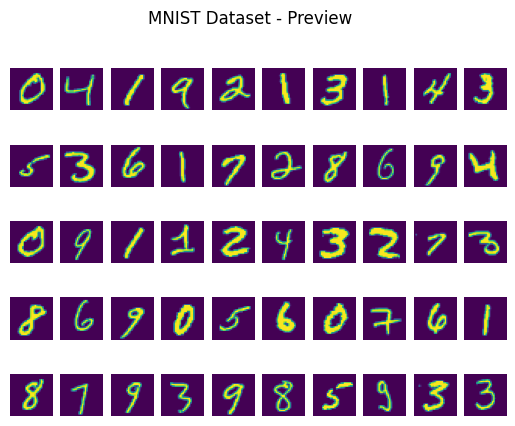

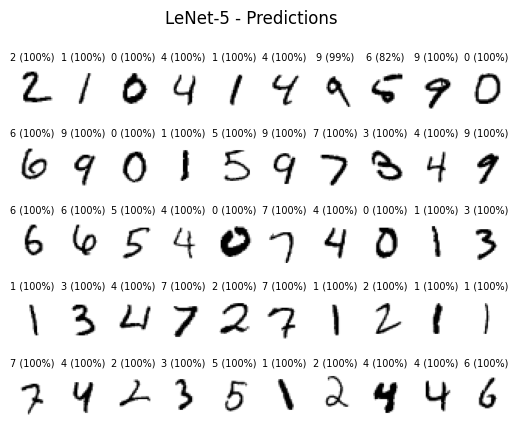

In [ ]:
# Set the parameters for the figure, including the number of rows and images per row
image_rows = 10
total_rows = 5

# Create a figure for displaying MNIST dataset images
mnist_figure = plt.figure()

# Iterate through the images and add them to the figure
for idx in range(1, image_rows * total_rows + 1):
    plt.subplot(total_rows, image_rows, idx)  # Create a subplot
    plt.axis('off')  # Turn off the axis labels
    plt.imshow(training_dataset.data[idx])  # Display an image from the training dataset

mnist_figure.suptitle('MNIST Dataset - Preview')  # Add a title to the figure

# Create a new figure for displaying LeNet-5 predictions
predictions_figure = plt.figure()

# Iterate through the images and add them to the figure
for idx in range(1, image_rows * total_rows + 1):
    plt.subplot(total_rows, image_rows, idx)  # Create a subplot
    plt.axis('off')  # Turn off the axis labels
    plt.imshow(validation_dataset.data[idx], cmap='gray_r')  # Display an image from the validation dataset

    with torch.no_grad():
        model.eval()  # Set the model to evaluation mode
        _, probabilities = model(validation_dataset[idx][0].unsqueeze(0))  # Get model predictions

    predicted_class = torch.argmax(probabilities)
    confidence_percentage = torch.max(probabilities * 100)
    title = f'{predicted_class} ({confidence_percentage:.0f}%)'  # Generate a title with the predicted class and confidence

    plt.title(title, fontsize=7)  # Add the title to the subplot

predictions_figure.suptitle('LeNet-5 - Predictions')  # Add a title to the LeNet-5 predictions figure


In [ ]:
# Remove the 'mnist_data' directory and its contents
!rm -r mnist_data

# Comments:
# This line of code removes the directory 'mnist_data' and all of its contents recursively.
# It is typically used to clean up or delete a directory and its contents from the file system.
# The '!' at the beginning of the command indicates that it's a shell command executed from within a Jupyter notebook or a similar environment.
